In [1]:
import torch
from torchvision import datasets, transforms
from denoising_diffusion_pytorch import Unet, GaussianDiffusion,Trainer
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

/NAS/PROJECTS/BOMRGD/envs/ddpm_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils

In [2]:
# prompt: write a function that plots in a same subplot with 3 columns the n first elements of X1_batch, X2_batch, X3_batch
def plot_multimodal_mnist(X1_batch, X2_batch, X3_batch, n=10):
    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(5,  n))
    for i in range(n):
        axes[i, 0].imshow(X1_batch[i].permute(1, 2, 0))
        axes[i, 0].axis('off')
        axes[i, 1].imshow(X2_batch[i].permute(1, 2, 0))
        axes[i, 1].axis('off')
        axes[i, 2].imshow(X3_batch[i].permute(1, 2, 0))
        axes[i, 2].axis('off')
    plt.tight_layout()
    plt.show()

In [3]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def plot_b_n_images(images,k=5):
    """
    Plots a tensor of shape (b, n, c, h, w) in a grid with b rows and n columns.

    Args:
        images (torch.Tensor): A tensor of shape (b, n, c, h, w).
    """
    images = images[:min(k,images.shape[0])]
    
    b, n, c, h, w = images.shape  # Extract dimensions
    
    # Reshape to (b*n, c, h, w) for grid plotting
    images = images.view(b * n, c, h, w)

    # Create grid (n images per row, hence `nrow=n`)
    grid = vutils.make_grid(images, nrow=n, padding=2, normalize=True)

    # Convert grid to numpy and plot
    plt.figure(figsize=(n * 2, b * 2))
    plt.axis("off")
    plt.imshow(grid.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.show()


# Dataset

In [4]:
# class MultimodalMNIST(torch.utils.data.Dataset):
#     """
#     For each MNIST digit (28x28), produce 3 "color" versions:
#       X1: red,  X2: green,  X3: blue.
#     Each is [3, 28, 28] but only one channel is nonzero.
#     """
#     def __init__(self, root='../MNIST/data', train=True, transform=None, download=True, labeled=False):
#         self.mnist = datasets.MNIST(root=root, train=train, download=download, transform=transform)
#         self.labeled = labeled
    
#     def __len__(self):
#         return len(self.mnist)

#     def _make_color(self, gray_img, channel_idx):
#         # gray_img: [1,28,28], channel_idx in {0,1,2}
#         rgb = torch.zeros(3, 28, 28)
#         rgb[channel_idx] = gray_img[0]
#         return rgb

#     def __getitem__(self, idx):
#         gray_img, label = self.mnist[idx]
#         X1 = self._make_color(gray_img, 0)  # Red
#         X2 = self._make_color(gray_img, 1)  # Green
#         X3 = self._make_color(gray_img, 2)  # Blue
#         if self.labeled:
#             return (X1, X2, X3), label
#         return (X1, X2, X3)


# transform = transforms.Compose([transforms.ToTensor()])
# train_set = MultimodalMNIST(train=True,  transform=transform, download=True, labeled=False)
# test_set  = MultimodalMNIST(train=False, transform=transform, download=True, labeled=False)

# train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
# test_loader  = DataLoader(test_set,  batch_size=64, shuffle=False)

# X1_batch, X2_batch, X3_batch = next(iter(train_loader))
# print("X1 shape:", X1_batch.shape)  # [B,3,28,28]


In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random

class MultimodalMNIST(torch.utils.data.Dataset):
    """
    For each MNIST digit (28x28), produce 3 "color" versions:
      X1: red (from original digit),
      X2: green (from original digit),
      X3: blue (from a **random** different digit).
    Each is [3, 28, 28] but only one channel is nonzero.
    """
    def __init__(self, root='../MNIST/data', train=True, transform=None, download=True, labeled=False, num_modalities=3, stacked=True):
        self.mnist = datasets.MNIST(root=root, train=train, download=download, transform=transform)
        self.labeled = labeled
        self.indices = list(range(len(self.mnist)))  # Store indices to sample randomly for X3
        self.num_modalities=num_modalities
        self.stacked=stacked
        
    def __len__(self):
        return len(self.mnist)

    def _make_color(self, gray_img, channel_idx):
        # Convert grayscale image to a colored one by activating a single channel
        rgb = torch.zeros(3, 28, 28)
        rgb[channel_idx] = gray_img[0]
        return rgb

    def __getitem__(self, idx):
        # First digit (same for X1, X2)
        gray_img1, label1 = self.mnist[idx]

        # Pick a **random** different digit for X3
        random_idx = random.choice(self.indices)
        gray_img3, label3 = self.mnist[random_idx]

        # Assign colors: X1 (Red), X2 (Green), X3 (Blue)
        X1 = self._make_color(gray_img1, 0)  # Red

        if self.num_modalities == 1 :
            if self.labeled:
                return X1, label1  # Return both labels
            return X1
        
        X2 = self._make_color(gray_img1, 1)  # Green
        X3 = self._make_color(gray_img3, 2)  # Blue

        if self.stacked:
            # Stack the modalities along channel dimension (1)
            stacked_modalities = torch.cat([X1, X2, X3], dim=0)  # Shape: (num_modalities * channels, 28, 28)
            if self.labeled:
                return stacked_modalities, (label1, label3)  # Return stacked tensor and labels
            return stacked_modalities
            
        if self.labeled:
            return (X1, X2, X3), (label1, label3)  # Return both labels
        return (X1, X2, X3)

# Define transforms and create dataset
transform = transforms.Compose([transforms.ToTensor()])
train_set = MultimodalMNIST(train=True, transform=transform, download=True, labeled=False)
test_set  = MultimodalMNIST(train=False, transform=transform, download=True, labeled=False)

# Create dataloaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=64, shuffle=False)

# Fetch a batch
if train_set.stacked or train_set.num_modalities==1:
    X1_batch = next(iter(train_loader))
else:
    X1_batch, X2_batch, X3_batch = next(iter(train_loader))
print("X1 shape:", X1_batch.shape)  # [B,3,28,28]
# print("X3 digit labels (randomized):", labels3[:10])  # First 10 labels of random third digit


X1 shape: torch.Size([64, 9, 28, 28])


# No froward correlation

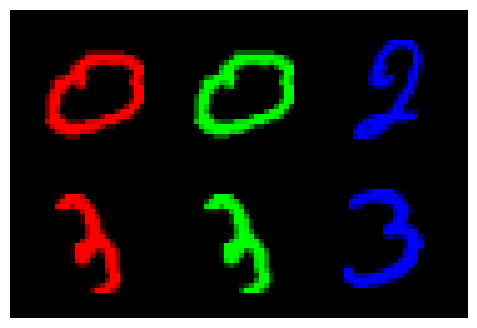

In [6]:
num_modalities = 3
# Define transforms and create dataset
transform = transforms.Compose([transforms.ToTensor()])
train_set = MultimodalMNIST(train=True, transform=transform, download=True, labeled=False, num_modalities=num_modalities)
test_set  = MultimodalMNIST(train=False, transform=transform, download=True, labeled=False, num_modalities=num_modalities)

# Create dataloaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=64, shuffle=False)

batch = next(iter(train_loader))
b,C,h,w = batch.shape
c = C//num_modalities
images = batch.view(b,num_modalities,c,h,w)
plot_b_n_images(images, 2)

In [22]:
image_size = 28
channels = 3
out_dim = channels*num_modalities
num_modalities_=None if num_modalities==1 else 3
# check Sigma
# model = Unet(
#     dim=64,
#     out_dim=out_dim,
#     channels=out_dim,
#     dim_mults=(1, 2, 2),
    # flash_attn=True,  # disable flash attention if on CPU
# )

model = Unet(
    dim = 64,
    out_dim=out_dim,
    channels=out_dim,
    dim_mults = (1, 2, 4),
    flash_attn = True
)

diffusion = GaussianDiffusion( 
    model,
    image_size=image_size,
    timesteps=1000,
    num_modalities=num_modalities_,
    correlated=True,
    return_identity = False)
    # num_modalities=num_modalities)



trainer = Trainer(
    diffusion,
    'path/to/your/images',
    results_folder = './results',
    train_batch_size = 32,
    train_lr = 8e-5,
    train_num_steps = 10000, #700000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
    calculate_fid = False,              # whether to calculate fid during training,
    dl = train_loader,
    # inception_weights_path = '../evaluation_models/inception_v3_google-0cc3c7bd.pth',
    save_and_sample_every = 1000
    
    
)


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
 trainer.train()

  0%|          | 0/10000 [00:00<?, ?it/s]/NAS/PROJECTS/BOMRGD/envs/ddpm_env/lib/python3.8/contextlib.py:83: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
loss: 0.0959:   4%|▍         | 407/10000 [01:35<36:54,  4.33it/s]

In [16]:
L = diffusion.get_L()

In [21]:
L

tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]],
       device='cuda:0', grad_fn=<IndexPutBackward0>)

In [11]:
plt.imshow(L.detach().cpu().numpy())
plt.show()

In [12]:
trainer.results_folder

PosixPath('results')

In [13]:
error

NameError: name 'error' is not defined

In [ ]:
training_images = next(iter(train_loader))[0]

In [ ]:
training_images[0].shape

In [ ]:
# --- Test Unconditional Training ---
# Create a batch of 8 random training images in [0, 1]
# training_images = torch.rand(8, 2,  3, image_size, image_size)
loss = diffusion(training_images)
loss.backward()
print("Unconditional training loss:", loss.item())

In [ ]:
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    flash_attn = True
)

diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000,           # number of steps
    sampling_timesteps = 250    # number of sampling timesteps (using ddim for faster inference [see citation for ddim paper])
)

trainer = Trainer(
    diffusion,
    'path/to/your/images',
    train_batch_size = 32,
    train_lr = 8e-5,
    train_num_steps = 700000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
    calculate_fid = True              # whether to calculate fid during training
)

trainer.train()

# Forward and backward correlation